<a href="https://colab.research.google.com/github/jacqeinz/SentimentAnalysis/blob/main/Spring2024.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive
import numpy as np
import pandas as pd
import numpy as np
import pandas as pd
import re
import nltk
import spacy
import string
%matplotlib inline
!pip install sentence-transformers
from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()  # for plot styling
from sklearn.preprocessing import MinMaxScaler
!pip install vadersentiment
from sklearn.base import ClusterMixin, BaseEstimator
from sklearn.cluster import KMeans
!pip install xgboost
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
!pip install transformers flair
# Hugging Face model
from transformers import pipeline

# Import flair pre-trained sentiment model
from flair.models import TextClassifier

df_test = pd.read_csv('/gdrive/My Drive/drug_review_test.csv')
df_train = pd.read_csv('/gdrive/My Drive/drug_review_train.csv')
df_validation = pd.read_csv('/gdrive/My Drive/drug_review_validation.csv')
df_reviews = pd.read_csv('/gdrive/My Drive/review_agreement.csv')

  Using cached https://github.com/pandas-profiling/pandas-profiling/archive/master.zip
  Preparing metadata (setup.py) ... done
Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive


In [ ]:
df_test_copy = df_test.copy()
df_train_copy = df_train.copy()
df_validation_copy = df_validation.copy()
df_reviews_copy = df_reviews.copy()

In [ ]:
print(df_test_copy.head())

   Unnamed: 0  patient_id         drugName                     condition  \
0           0      163740      Mirtazapine                    depression   
1           1      206473       Mesalamine  crohn's disease, maintenance   
2           2       39293         Contrave                   weight loss   
3           3       97768  Cyclafem 1 / 35                 birth control   
4           4      208087          Zyclara                     keratosis   

                                              review  rating  \
0  "i've tried a few antidepressants over the yea...    10.0   
1  "my son has crohn's disease and has done very ...     8.0   
2  "contrave combines drugs that were used for al...     9.0   
3  "i have been on this birth control for one cyc...     9.0   
4  "4 days in on first 2 weeks.  using on arms an...     4.0   

                date  usefulCount  review_length  
0  February 28, 2012           22             68  
1       May 17, 2009           17             48  
2    

In [ ]:
mydata = df_test_copy.drop('Unnamed: 0', axis=1)
# df_reviews_copy = df_reviews_copy.drop('Unnamed: 0', axis=1)

In [ ]:
df_review = mydata[["review"]]
df_review["review"] = df_review["review"].astype(str)

pd.options.mode.chained_assignment = None

<ipython-input-5-41cffc71ed4f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_review["review"] = df_review["review"].astype(str)


In [ ]:

df_reviews_copy["review"] = df_reviews_copy["review"].astype(str)

In [ ]:
#import nltk
#nltk.download('punkt')
#from nltk.tokenize import word_tokenize
#from nltk import pos_tag
#nltk.download('stopwords')
#from nltk.corpus import stopwords
#nltk.download('wordnet')
#from nltk.corpus import wordnet
#nltk.download('averaged_perceptron_tagger')
# POS tagger dictionary
#pos_dict = {'J':wordnet.ADJ, 'V':wordnet.VERB, 'N':wordnet.NOUN, 'R':wordnet.ADV}
#def token_stop_pos(text):
#    tags = pos_tag(word_tokenize(text))
#    newlist = []
#    for word, tag in tags:
#        if word.lower() not in set(stopwords.words('english')):
 #         newlist.append(tuple([word, pos_dict.get(tag[0])]))
  #  return newlist

#df_review['POS tagged'] = df_review['Cleaned Reviews'].apply(token_stop_pos)

In [ ]:
#from nltk.stem import WordNetLemmatizer
#wordnet_lemmatizer = WordNetLemmatizer()
#def lemmatize(pos_data):
#    lemma_rew = " "
 #   for word, pos in pos_data:
  #    if not pos:
   #     lemma = word
   #     lemma_rew = lemma_rew + " " + lemma
    #  else:
     #   lemma = wordnet_lemmatizer.lemmatize(word, pos=pos)
     #   lemma_rew = lemma_rew + " " + lemma
#    return lemma_rew

#df_review['Lemma'] = df_review['Cleaned Reviews'].apply(lemmatize)

In [ ]:
! pip install umap-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.9/90.9 kB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 7.7 MB/s eta 0:00:00
  Created wheel for umap-learn: filename=umap_learn-0.5.5-py3-none-any.whl size=86832 sha256=9e9e053f95d289ee0567f0cca74503a1e68556035bab7df97fa81749eccf1627
  Stored in directory: /root/.cache/pip/wheels/3a/70/07/428d2b58660a1a3b431db59b806a10da736612ebbc66c1bcc5
Successfully built umap-learn


In [ ]:
from sentence_transformers import SentenceTransformer
sbert_model = SentenceTransformer('bert-base-nli-mean-tokens')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.99k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/399 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
# Define a function to clean the text
def clean(text):
# Removes all special characters and numericals leaving the alphabets
    text = re.sub('[^A-Za-z]+', ' ', text)
    return text

# Cleaning the text in the review column
df_review['Cleaned Reviews'] =df_review['review'].apply(clean)

In [ ]:
# Define a function to clean the text
def clean(text):
# Removes all special characters and numericals leaving the alphabets
    text = re.sub('[^A-Za-z]+', ' ', text)
    return text

# Cleaning the text in the review column
df_reviews_copy['Cleaned Reviews'] =df_reviews_copy["review"].apply(clean)

In [ ]:
df_review['Embeddings'] = df_review['Cleaned Reviews'].apply(lambda x: sbert_model.encode(x))

In [ ]:
df_reviews_copy['Embeddings'] = df_reviews_copy['Cleaned Reviews'].apply(lambda x: sbert_model.encode(x))

In [ ]:
from sklearn.svm import SVC # for Support Vector Classification baseline model
from sklearn.semi_supervised import SelfTrainingClassifier # for Semi-Supervised learning
from sklearn.metrics import classification_report

In [ ]:
df_review['majority'] = -1
df_review['Random_Mask'] = True
df_reviews_copy['Random_Mask'] = False

In [ ]:
from sklearn.metrics import precision_recall_curve

In [ ]:
df_concat = pd.concat([df_review, df_reviews_copy])

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
import umap
Y = df_concat['Embeddings']
embeddings_UMAP = umap.UMAP(n_components = 1, metric="cosine", random_state=42).fit_transform(Y.to_list())
#Define new column for new pca reduced embeddings

df_concat['Embeddings_Reduced'] = np.array(embeddings_UMAP)
#Add new embeddings to the dataframe
# for index in range(len(df_concat)):
#    df_concat.Embeddings_Reduced[index] = embeddings_UMAP[index]

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [ ]:
Y = df_reviews_copy['Embeddings']
embeddings_UMAP = umap.UMAP(n_components = 1, metric="cosine", random_state=42).fit_transform(Y.to_list())
#Define new column for new pca reduced embeddings

df_reviews_copy['Embeddings_Reduced'] = np.array(embeddings_UMAP)

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [ ]:
df_concat.drop(columns=['Embeddings'], inplace=True)

In [ ]:
df_train, df_test = train_test_split(df_concat, test_size=0.25, random_state=0)

In [ ]:
df_train['Random_Mask'] = True
df_train.loc[df_train.sample(frac=0.05, random_state=0).index, 'Random_Mask'] = False

# Create a new target colum with labels. The 1's and 0's are original labels and -1 represents unlabeled (masked) data
df_train['Target']=df_train.apply(lambda x: x['majority'] if x['Random_Mask']==False else -1, axis=1)

In [ ]:
print(df_train['Target'].value_counts())

Target
-1    34720
 0        7
 1        4
Name: count, dtype: int64


In [ ]:

df_train_labeled=df_train[df_train['Target']!=-1]

In [ ]:
X_baseline=df_train_labeled[['Embeddings_Reduced']]
y_baseline=df_train_labeled['Target'].values


In [ ]:
X_test=df_reviews_copy[['Embeddings_Reduced']]
y_test=df_reviews_copy['majority'].values

In [ ]:
model = SVC(kernel='rbf',
            probability=True,
            C=1.0, # default = 1.0
            gamma='scale', # default = 'scale'
            random_state=0
           )

In [ ]:
# print(X_baseline.shape)
# print(y_baseline.shape)

In [ ]:
# print(X_baseline)

In [ ]:
# print(y_baseline)

In [ ]:

y_baseline = np.array(y_baseline)
X_baseline = np.array(X_baseline)

In [ ]:
# y_baseline = np.ravel(y_baseline)
# # y_baseline = y_baseline.reshape(-1,1)
# X_baseline = np.ravel(X_baseline)
# # X_baseline = X_baseline.reshape(-1,1)

In [ ]:
# import umap
# Y = X_baseline['Embeddings']
# embeddings_UMAP = umap.UMAP(n_components = 1, metric="cosine", random_state=42).fit_transform(Y.to_list())
# #Define new column for new pca reduced embeddings

# X_baseline['Embeddings_Reduced'] = X_baseline['Embeddings'].str.len()
# #Add new embeddings to the dataframe
# for index in range(len(X_baseline)):
#    X_baseline.Embeddings_Reduced[index] = embeddings_UMAP[index]


In [ ]:
# X_baseline.drop(columns=['Embeddings'], inplace=True)

In [ ]:
# result = np.where(X_baseline=='')[0]
# X_baseline = np.delete(X_baseline,result)

In [ ]:
# y_baseline = np.array(y_baseline ,dtype = np.float32 )
# X_baseline = np.array(X_baseline, dtype= np.float32)

In [ ]:
clf = model.fit(X_baseline, y_baseline)

In [ ]:
# df_train, df_test = train_test_split(df_concat, test_size=0.25, random_state=0)

In [ ]:
# X_train = df_train[['Embeddings']]


In [ ]:
# model_svc = SVC(kernel='rbf',
#                 probability=True, # Need to enable to be able to use predict_proba
#                 C=1.0, # default = 1.0
#                 gamma='auto', # default = 'scale',
#                 random_state=0
#                )


In [ ]:
# Y = X_train['Embeddings']
# embeddings_UMAP = umap.UMAP(n_components = 1, metric="cosine", random_state=42).fit_transform(Y.to_list())
# Define new column for new pca reduced embeddings

# X_train['Embeddings_Reduced'] = np.zeros(X_train['Embeddings'].shape[0])
# Add new embeddings to the dataframe
# for index in range(len(X_train)):
#    X_train.Embeddings_Reduced[index] = embeddings_UMAP[index]

In [ ]:
# X_train.drop(columns=['Embeddings'], inplace=True)

In [ ]:
X_train = df_train[['Embeddings_Reduced']]
y_train = df_train['Target'].values

In [ ]:
model_svc = SVC(kernel='rbf',
                probability=True, # Need to enable to be able to use predict_proba
                C=1.0, # default = 1.0
                gamma='scale', # default = 'scale',
                random_state=0
               )

In [ ]:
self_training_model = SelfTrainingClassifier(base_estimator=model_svc, # An estimator object implementing fit and predict_proba.
                                             threshold=0.7, # default=0.75, The decision threshold for use with criterion='threshold'. Should be in [0, 1).
                                             criterion='k_best', # {‘threshold’, ‘k_best’}, default=’threshold’, The selection criterion used to select which labels to add to the training set. If 'threshold', pseudo-labels with prediction probabilities above threshold are added to the dataset. If 'k_best', the k_best pseudo-labels with highest prediction probabilities are added to the dataset.
                                             k_best=50, # default=10, The amount of samples to add in each iteration. Only used when criterion='k_best'.
                                             max_iter=100, # default=10, Maximum number of iterations allowed. Should be greater than or equal to 0. If it is None, the classifier will continue to predict labels until no new pseudo-labels are added, or all unlabeled samples have been labeled.
                                             verbose=True # default=False, Verbosity prints some information after each iteration
                                            )


In [ ]:
clf_ST = self_training_model.fit(X_train, y_train)


End of iteration 1, added 50 new labels.
End of iteration 2, added 50 new labels.
End of iteration 3, added 50 new labels.
End of iteration 4, added 50 new labels.
End of iteration 5, added 50 new labels.
End of iteration 6, added 50 new labels.
End of iteration 7, added 50 new labels.
End of iteration 8, added 50 new labels.
End of iteration 9, added 50 new labels.
End of iteration 10, added 50 new labels.
End of iteration 11, added 50 new labels.
End of iteration 12, added 50 new labels.
End of iteration 13, added 50 new labels.
End of iteration 14, added 50 new labels.
End of iteration 15, added 50 new labels.
End of iteration 16, added 50 new labels.
End of iteration 17, added 50 new labels.
End of iteration 18, added 50 new labels.
End of iteration 19, added 50 new labels.
End of iteration 20, added 50 new labels.
End of iteration 21, added 50 new labels.
End of iteration 22, added 50 new labels.
End of iteration 23, added 50 new labels.
End of iteration 24, added 50 new labels.
E

In [ ]:
# X_test=df_test[['Embeddings']]
# y_test=df_test['majority'].values

In [ ]:
# Y = X_test['Embeddings']
# embeddings_UMAP = umap.UMAP(n_components = 1, metric="cosine", random_state=42).fit_transform(Y.to_list())
# #Define new column for new pca reduced embeddings

# X_test['Embeddings_Reduced'] = X_test['Embeddings'].str.len()
# #Add new embeddings to the dataframe
# for index in range(len(X_test)):
#    X_test.Embeddings_Reduced[index] = embeddings_UMAP[index]


In [ ]:
# X_test=X_test[['Embeddings_Reduced']]

In [ ]:
# X_test.drop(columns=['Embeddings'], inplace=True)

In [ ]:
print('')
print('---------- Self Training Model - Summary ----------')
print('Base Estimator: ', clf_ST.base_estimator_)
print('Classes: ', clf_ST.classes_)
print('Transduction Labels: ', clf_ST.transduction_)
#print('Iteration When Sample Was Labeled: ', clf_ST.labeled_iter_)
print('Number of Features: ', clf_ST.n_features_in_)
print('Feature Names: ', clf_ST.feature_names_in_)
print('Number of Iterations: ', clf_ST.n_iter_)
print('Termination Condition: ', clf_ST.termination_condition_)
print('')

print('---------- Self Training Model - Evaluation on Test Data ----------')
accuracy_score_ST = clf_ST.score(X_test, y_test)
print('Accuracy Score: ', accuracy_score_ST)
# Look at classification report to evaluate the model
print(classification_report(y_test, clf_ST.predict(X_test), zero_division=0))


---------- Self Training Model - Summary ----------
Base Estimator:  SVC(probability=True, random_state=0)
Classes:  [0 1]
Transduction Labels:  [ 0 -1 -1 ... -1 -1 -1]
Number of Features:  1
Feature Names:  ['Embeddings_Reduced']
Number of Iterations:  100
Termination Condition:  max_iter

---------- Self Training Model - Evaluation on Test Data ----------
Accuracy Score:  0.6467661691542289
              precision    recall  f1-score   support

           0       0.63      0.98      0.77       120
           1       0.86      0.15      0.25        81

    accuracy                           0.65       201
   macro avg       0.74      0.57      0.51       201
weighted avg       0.72      0.65      0.56       201



In [ ]:
df_concat['Pred_labels'] = clf_ST.predict(df_concat[['Embeddings_Reduced']])

In [ ]:
print(df_concat['Pred_labels'].value_counts())

Pred_labels
0    33772
1    12537
Name: count, dtype: int64


In [ ]:
Y = df_review['Embeddings']
embeddings_UMAP = umap.UMAP(n_components = 2, metric="cosine", random_state=42).fit_transform(Y.to_list())
#Define new column for new pca reduced embeddings
df_review['Embeddings_Reduced'] = ""
#Add new embeddings to the dataframe
for index in range(len(df_review)):
   df_review.Embeddings_Reduced[index] = embeddings_UMAP[index]
print(len(df_review.Embeddings_Reduced[0]))

Streaming output truncated to the last 5000 lines.
df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df_review.Embeddings_Reduced[index] = embeddings_UMAP[index]
<ipython-input-56-0c272fe9d624>:7: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_

In [ ]:
first_pos = (df_review['Embeddings_Reduced'].loc[df_review.index[3]])
sec_pos = (df_review['Embeddings_Reduced'].loc[df_review.index[4]])
third_pos = (df_review['Embeddings_Reduced'].loc[df_review.index[5]])
four_pos = (df_review['Embeddings_Reduced'].loc[df_review.index[8]])
fifth_pos = (df_review['Embeddings_Reduced'].loc[df_review.index[15]])

In [ ]:
first_neg = (df_review['Embeddings_Reduced'].loc[df_review.index[16]])
sec_neg = (df_review['Embeddings_Reduced'].loc[df_review.index[17]])
third_neg = (df_review['Embeddings_Reduced'].loc[df_review.index[19]])
four_neg = (df_review['Embeddings_Reduced'].loc[df_review.index[35]])
fifth_neg = (df_review['Embeddings_Reduced'].loc[df_review.index[38]])

In [ ]:
pos_avg = (first_pos + sec_pos + third_pos + four_pos + fifth_pos)/5

In [ ]:
neg_avg = (first_neg + sec_neg + third_neg + four_neg + fifth_neg)/5

In [ ]:
# reading_list = (df_review['Embeddings_Reduced'].loc[df_review.index[16, 17, 19, 31, 35, 38, 40, 41, 44, 46, 48, 51, 53, 54, 55, 58, 59, 60, 63, 64, 76, 81, 92, 98, 102, 104, 111, 112, 113, 114, 125, 131, 133, 137, 145, 149, 155, 176, 186, 192, 195, 204, 212, 220, 234, 236, 239, 246, 247, 250, 251, 280, 285, 288, 289, 296, 302, 304, 309, 310, 328, 333, 335, 337, 338, 340, 341, 351, 362, 364, 367, 371, 373, 375, 384, 407, 461, 473, 483, 486, 537, 545, 593, 632, 640, 728, 729, 740, 770, 805, 853, 855, 901, 939, 997, 1070, 1077, 1136,1137, 1150, 1206, 2, 3, 4, 5, 8, 15, 18, 20, 22, 23, 24, 29, 30, 32, 33, 37, 39, 45, 49, 50, 52, 57, 61, 65, 67, 69, 74, 78, 79, 80, 82, 85, 86, 90, 95, 97, 99, 100, 106, 109, 110, 116, 117, 119, 135, 136, 140, 152, 153, 156, 158, 161, 163, 165, 167, 170, 171, 172, 173, 174, 177, 178, 179, 181, 185, 197, 201, 208, 209, 216, 217, 222, 225, 226, 227, 228, 229, 235, 242, 243, 253, 254, 258, 259, 262, 264, 266, 267, 269, 271, 273, 275, 279, 284, 286, 292, 299, 307, 308, 311]])

In [ ]:
# list = [16, 17, 19, 31, 35, 38, 40, 41, 44, 46, 48, 51, 53, 54, 55, 58, 59, 60, 63, 64, 76, 81, 92, 98, 102, 104, 111, 112, 113, 114, 125, 131, 133, 137, 145, 149, 155, 176, 186, 192, 195, 204, 212, 220, 234, 236, 239, 246, 247, 250, 251, 280, 285, 288, 289, 296, 302, 304, 309, 310, 328, 333, 335, 337, 338, 340, 341, 351, 362, 364, 367, 371, 373, 375, 384, 407, 461, 473, 483, 486, 537, 545, 593, 632, 640, 728, 729, 740, 770, 805, 853, 855, 901, 939, 997, 1070, 1077, 1136,1137, 1150, 1206, 2, 3, 4, 5, 8, 15, 18, 20, 22, 23, 24, 29, 30, 32, 33, 37, 39, 45, 49, 50, 52, 57, 61, 65, 67, 69, 74, 78, 79, 80, 82, 85, 86, 90, 95, 97, 99, 100, 106, 109, 110, 116, 117, 119, 135, 136, 140, 152, 153, 156, 158, 161, 163, 165, 167, 170, 171, 172, 173, 174, 177, 178, 179, 181, 185, 197, 201, 208, 209, 216, 217, 222, 225, 226, 227, 228, 229, 235, 242, 243, 253, 254, 258, 259, 262, 264, 266, 267, 269, 271, 273, 275, 279, 284, 286, 292, 299, 307, 308, 311]

In [ ]:
# reading_list = df_review.iloc[list]

In [ ]:
# reading_list.to_csv('/gdrive/My Drive/reading_list.csv', index=False)

In [ ]:
#df_review.describe()

In [ ]:
#df_review.head()

In [ ]:
# df_review.dtypes
# from google.colab import files

# df_review.to_csv('/gdrive/My Drive/mydata_reduced.csv', index=False)

In [ ]:
X = df_review['Embeddings_Reduced'].tolist()

X = MinMaxScaler().fit_transform(np.array(X))


In [ ]:
df_review.head

<bound method NDFrame.head of                                                   review  \
0      "i've tried a few antidepressants over the yea...   
1      "my son has crohn's disease and has done very ...   
2      "contrave combines drugs that were used for al...   
3      "i have been on this birth control for one cyc...   
4      "4 days in on first 2 weeks.  using on arms an...   
...                                                  ...   
46103  "i started taking apri about 7 months ago. my ...   
46104  "i have taken tamoxifen for 5 years. side effe...   
46105  "i've been taking lexapro (escitaploprgram) si...   
46106  "i'm married, 34 years old and i have no kids....   
46107  "i was prescribed nucynta for severe neck/shou...   

                                         Cleaned Reviews  \
0       i ve tried a few antidepressants over the yea...   
1       my son has crohn s disease and has done very ...   
2       contrave combines drugs that were used for al...   
3       i have been on this birth control for one cyc...   
4       days in on first weeks using on arms and face...   
...                                                  ...   
46103   i started taking apri about months ago my bre...   
46104   i have taken tamoxifen for years side effects...   
46105   i ve been taking lexapro escitaploprgram sinc...   
46106   i m married years old and i have no kids taki...   
46107   i was prescribed nucynta for severe neck shou...   

                                              Embeddings  majority  \
0      [-0.32237193, 0.8229566, 0.15864046, -0.113836...        -1   
1      [-0.8032229, 1.0158585, 0.17127746, -0.0187987...        -1   
2      [-0.48958772, 0.9372113, -0.44049883, -0.22041...        -1   
3      [-0.30430713, 0.6823951, 0.11862448, -0.105457...        -1   
4      [-0.454017, 1.0142777, 0.74158233, -0.07320624...        -1   
...                                                  ...       ...   
46103  [-0.550306, 0.82139415, -0.4156748, -0.1844812...        -1   
46104  [-0.44881457, 0.7342493, -0.0471674, -0.32527,...        -1   
46105  [-0.33864528, 0.7080815, 0.16179919, -0.034474...        -1   
46106  [-0.3918982, 0.73509544, 0.43847978, -0.116025...        -1   
46107  [-0.16940963, 1.1152735, -0.4359587, -0.233951...        -1   

       Random_Mask       Embeddings_Reduced  
0             True   [3.1215754, 3.5430064]  
1             True   [1.3919142, 1.9436579]  
2             True    [4.707487, 1.9627503]  
3             True   [2.2592633, 0.9123022]  
4             True    [5.828356, 3.0252676]  
...            ...                      ...  
46103         True   [2.5411074, 1.1745924]  
46104         True   [6.4282446, 0.6393913]  
46105         True    [5.248589, 1.8523333]  
46106         True  [5.753069, -0.50419503]  
46107         True   [4.4271092, 1.8331906]  

[46108 rows x 6 columns]>

In [ ]:


#X = np.array(df_review['Embeddings']).reshape(-1,1)

import sklearn
#0-positive, 1-negative
kmeans = sklearn.cluster.KMeans(n_clusters=2,init=[pos_avg, neg_avg],random_state=0)
kmeans.fit(X)
print("\n\n Cluster Center: \n\n ")
print(kmeans.cluster_centers_)

print("\n\n Lables")
print(kmeans.labels_)
df_review['Labels'] = kmeans.labels_
# Import PyDrive and associated libraries.
# This only needs to be done once in a notebook.

#y_kmeans = kmeans.predict(df_review['Embeddings'])
# from sklearn.metrics import pairwise_distances_argmin

# def find_clusters(X, n_clusters, rseed=2):
#     # 1. Randomly choose clusters
#     rng = np.random.RandomState(rseed)
#     i = rng.permutation(X.shape[0])[:n_clusters]
#     centers = X[i]

#     while True:
#         # 2a. Assign labels based on closest center
#         labels = pairwise_distances_argmin(X, centers)

#         # 2b. Find new centers from means of points
#         new_centers = np.array([X[labels == i].mean(0)
#                                 for i in range(n_clusters)])

#         # 2c. Check for convergence
#         if np.all(centers == new_centers):
#             break
#         centers = new_centers

#     return centers, labels

# centers, labels = find_clusters(X, 2)
# plt.scatter(X[:, 0], X[:, 1], c=labels,
#             s=50, cmap='viridis');
# print("\n\n Cluster Center: \n\n ")
# print(kmeans.cluster_centers_)

# print("\n\n Lables")
# print(kmeans.labels_)



 Cluster Center: 

 
[[0.7096666  0.51853657]
 [0.3203953  0.45937273]]


 Lables
[1 1 1 ... 1 1 1]


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1362: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  super()._check_params_vs_input(X, default_n_init=10)


In [ ]:
# df_review.to_csv('/gdrive/My Drive/my_data.csv', index=False)

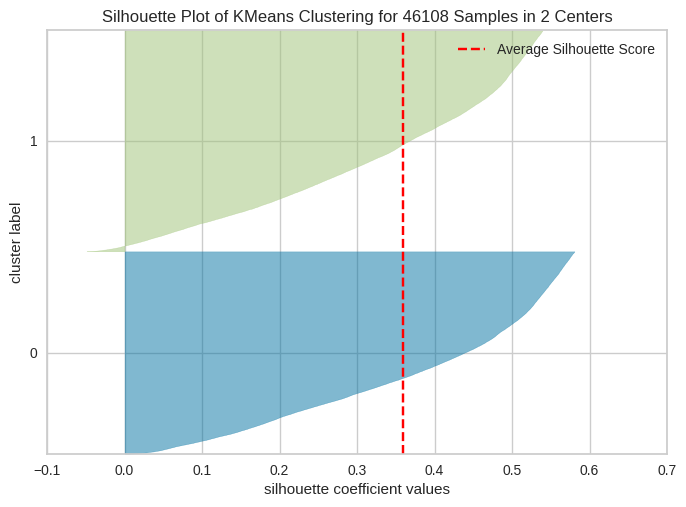

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 46108 Samples in 2 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [ ]:
from yellowbrick.cluster import SilhouetteVisualizer
# model = KMeans(2, random_state=42)
visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick')

visualizer.fit(X)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

In [ ]:
# skplt.metrics.plot_cumulative_gain(X, kmeans.labels_, title = 'Cumulative Gains Chart for Vader')

In [ ]:
# df_review.dtypes
# from google.colab import files

# df_review.to_csv('/gdrive/My Drive/mydata_reduced_labeled.csv', index=False)

In [ ]:
# my_centroids = np.array([[0.42858544],
#  [0.57396036]])
# kmeans = sklearn.cluster.KMeans(n_clusters=2, random_state=0, init="k-means++")
# kmeans.fit(X)
# print("\n\n Cluster Center: \n\n ")
# print(kmeans.cluster_centers_)

# print("\n\n Lables")
# print(kmeans.labels_)



In [ ]:
df_test_copy_nltk = df_review.copy()
# last_row = df_test_copy_nltk.tail(1)
# df_test_copy_nltk.append(last_row)

In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re


nltk.download('stopwords')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = re.sub(r'[^\w\s]', '', text, re.UNICODE) # remove punctuation
    text = text.lower() # convert to lowercase
    text = [lemmatizer.lemmatize(token) for token in text.split(" ")] # lemmatization
    text = [word for word in text if not word in stop_words] # remove stopwords
    text = " ".join(text)
    return text

# Apply the text cleaning function to our data
df_test_copy_nltk['Lemmatized_Reviews'] = df_test_copy_nltk.review.apply(lambda x: clean_text(x))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
# nltk.download('stopwords')
# nltk.download('wordnet')

# stop_words = set(stopwords.words('english'))
# lemmatizer = WordNetLemmatizer()

# def clean_text(text):
#     text = re.sub(r'[^\w\s]', '', text, re.UNICODE) # remove punctuation
#     text = text.lower() # convert to lowercase
#     text = [lemmatizer.lemmatize(token) for token in text.split(" ")] # lemmatization
#     text = [word for word in text if not word in stop_words] # remove stopwords
#     text = " ".join(text)
#     return text

# # Apply the text cleaning function to our data
# df_review['Lemmatized_Reviews'] = df_review.Cleaned Review.apply(lambda x: clean_text(x))

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# vectorizer = TfidfVectorizer(max_features=50000)
# data_features = vectorizer.fit_transform(df_test_copy_nltk['Lemmatized_Reviews'])
# data_features = data_features.toarray()



In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_test_copy_nltk['Lemmatized_Reviews'], df_test_copy_nltk['Labels'], test_size=.5, random_state=42)


In [ ]:
# X_train, X_test, y_train, y_test = train_test_split(df_review['Lemmatized_Reviews'], df_review['majority'], test_size=.5, random_state=42)

In [ ]:

vectorizer = TfidfVectorizer(max_features=50000)

X_train_vec = vectorizer.fit_transform(X_train.ravel())
X_train_vec = X_train_vec.toarray()

<ipython-input-82-1d78c8a9b484>:3: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  X_train_vec = vectorizer.fit_transform(X_train.ravel())


In [ ]:
X_test_vec = vectorizer.transform(X_test.ravel())
X_test_vec = X_test_vec.toarray()
# y_test_vec = vectorizer.transform(y_test.ravel())
# y_test_vec = y_test_vec.toarray()
# y_train_vec = vectorizer.transform(y_train.ravel())
# y_train_vec = y_train_vec.toarray()
concat_reviews = df_concat['Cleaned Reviews']

<ipython-input-83-7c501c4a27e8>:1: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  X_test_vec = vectorizer.transform(X_test.ravel())


In [ ]:
# vectorizer = TfidfVectorizer(max_features=50000)

# X_test_pred = vectorizer.fit_transform(concat_reviews.ravel())
# X_test_pred = X_test_pred.toarray()

In [ ]:
df_review.head()
!pip install vadersentiment

In [ ]:
df_results = pd.DataFrame()
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()
# function to calculate vader sentiment
def vadersentimentanalysis(review):
    vs = analyzer.polarity_scores(review)
    return vs['compound']
df_results['Vader Sentiment'] = X_test.apply(vadersentimentanalysis)
# function to analyse
def vader_analysis(compound):
    if compound >= 0.0:
        return 0
    elif compound <= 0.0:
        return 1

df_results['Vader Analysis'] = df_results['Vader Sentiment'].apply(vader_analysis)
from sklearn.metrics import classification_report



In [ ]:
x_test_embedded = X_test.apply(lambda x: sbert_model.encode(x))

In [ ]:
Y = x_test_embedded
embeddings_UMAP = umap.UMAP(n_components = 1, metric="cosine", random_state=42).fit_transform(Y.to_list())
#Define new column for new pca reduced embeddings

X_test_embedded_reduced = np.array(embeddings_UMAP)

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [ ]:
pred_reduced = clf_ST.predict(X_test_embedded_reduced)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SelfTrainingClassifier was fitted with feature names
  warnings.warn(


In [ ]:

# df_results['Labels'] = kmeans.labels_
vader_label = df_results['Vader Analysis']
df_results['vader_label'] = vader_label
vader_label = vader_label[np.logical_not(np.isnan(vader_label))]
vader_label.head()


23503    0
24639    0
2984     0
19652    0
23101    0
Name: Vader Analysis, dtype: int64

In [ ]:
print(classification_report(y_test, vader_label))

              precision    recall  f1-score   support

           0       0.30      0.33      0.32     10961
           1       0.33      0.30      0.31     12093

    accuracy                           0.31     23054
   macro avg       0.32      0.32      0.31     23054
weighted avg       0.32      0.31      0.31     23054



In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
print(classification_report(pred_reduced, vader_label))

              precision    recall  f1-score   support

           0       0.52      0.43      0.47     14487
           1       0.25      0.31      0.28      8567

    accuracy                           0.39     23054
   macro avg       0.38      0.37      0.37     23054
weighted avg       0.42      0.39      0.40     23054



In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
print(accuracy_score(y_test, vader_label))

0.31426216708597204


In [ ]:
print(accuracy_score(pred_reduced, vader_label))


0.3890431161620543


In [ ]:
from sklearn.metrics import PrecisionRecallDisplay

Text(0.5, 1.0, 'Precision-Recall curve for Vader with KMeans')

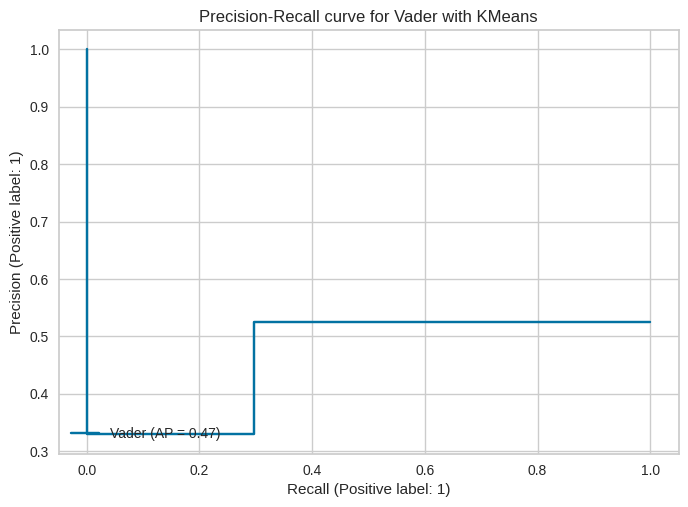

In [ ]:
display = PrecisionRecallDisplay.from_predictions(
    y_test, vader_label, name="Vader",
)
display.ax_.set_title("Precision-Recall curve for Vader with KMeans")


Text(0.5, 1.0, 'Precision-Recall curve for Vader with STC')

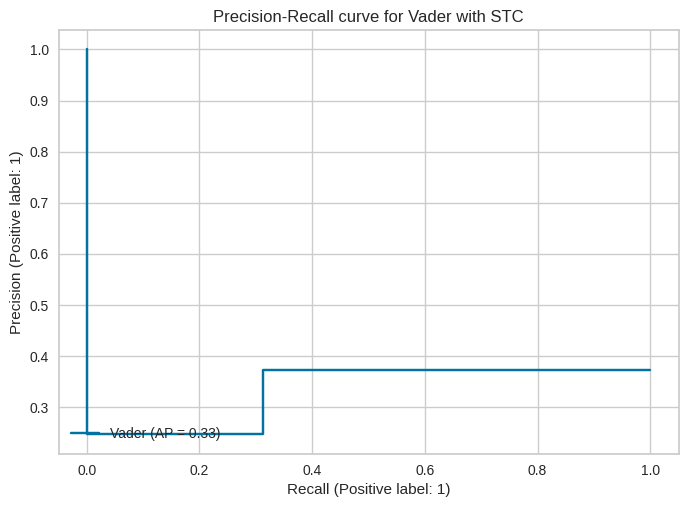

In [ ]:
display = PrecisionRecallDisplay.from_predictions(
    pred_reduced, vader_label, name="Vader"
)
display.ax_.set_title("Precision-Recall curve for Vader with STC")

In [ ]:
!pip install scikit-plot

<Axes: title={'center': 'Confusion Matrix for KMeans with Vader'}, xlabel='Predicted label', ylabel='True label'>

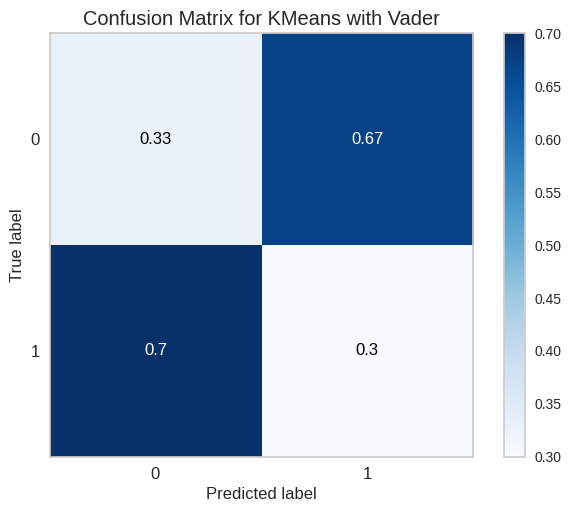

In [ ]:
import matplotlib.pyplot as plt
import scikitplot as skplt

skplt.metrics.plot_confusion_matrix(y_test, vader_label, normalize=True, title = 'Confusion Matrix for Vader with KMeans')
# skplt.metrics.plot_precision_recall(y_test, vader_label, title = 'PR Curve for Vader')
# skplt.metrics.plot_cumulative_gain(y_test, vader_label, title = 'Cumulative Gains Chart for Vader')

<Axes: title={'center': 'Confusion Matrix for STC with Vader'}, xlabel='Predicted label', ylabel='True label'>

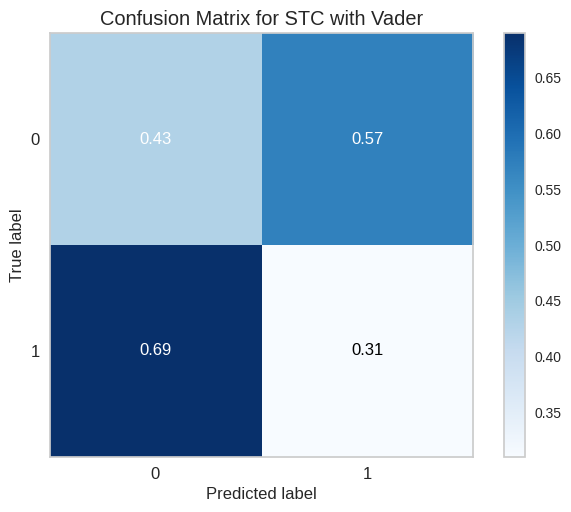

In [ ]:
skplt.metrics.plot_confusion_matrix(pred_reduced, vader_label, normalize=True, title = 'Confusion Matrix for Vader with STC')
# skplt.metrics.plot_precision_recall(y_test, pred_reduced, title = 'PR Curve for Vader')
# skplt.metrics.plot_cumulative_gain(y_test, pred_reduced, title = 'Cumulative Gains Chart for Vader')

In [ ]:
!pip install xgboost

In [ ]:
import xgboost as xgb

model = xgb.XGBClassifier(max_depth=10, n_estimators=100, learning_rate=0.01)
model.fit(X_train_vec, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [ ]:

X_test_vec = vectorizer.transform(X_test)


In [ ]:

# import pandas_categorical
X_test_xg = X_test.to_numpy()
# df_results['x_test'] = X_test
predictions = model.predict(X_test_vec)
# df_review['xgboost'] = predictions
df_results['xgboost'] = predictions

In [ ]:
from sklearn.metrics import classification_report

# true_labels =  df_test_copy_nltk['Labels'].toarray()

print(classification_report(y_test, df_results['xgboost']))

              precision    recall  f1-score   support

           0       0.47      0.95      0.63     10961
           1       0.48      0.04      0.07     12093

    accuracy                           0.47     23054
   macro avg       0.48      0.50      0.35     23054
weighted avg       0.48      0.47      0.34     23054



In [ ]:
from sklearn.metrics import classification_report

# true_labels =  df_test_copy_nltk['Labels'].toarray()

print(classification_report(pred_reduced, df_results['xgboost']))

              precision    recall  f1-score   support

           0       0.63      0.96      0.76     14487
           1       0.39      0.04      0.08      8567

    accuracy                           0.62     23054
   macro avg       0.51      0.50      0.42     23054
weighted avg       0.54      0.62      0.51     23054



<Axes: title={'center': 'Confusion Matrix for XGBoost with KMeans'}, xlabel='Predicted label', ylabel='True label'>

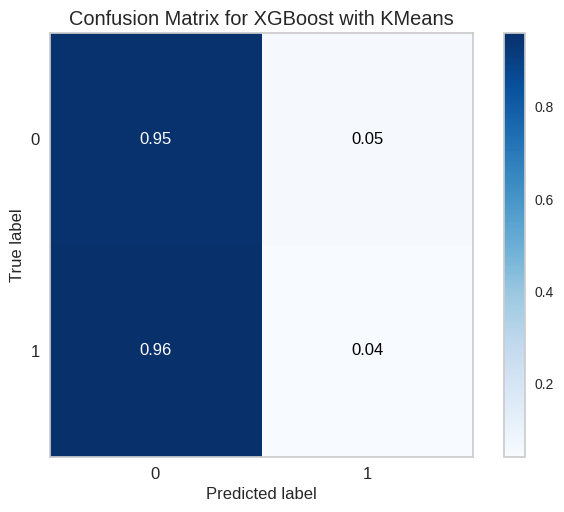

In [ ]:
skplt.metrics.plot_confusion_matrix(y_test, df_results['xgboost'], normalize=True, title = 'Confusion Matrix for XGBoost with KMeans')
# skplt.metrics.plot_precision_recall(y_test, df_results['xgboost'], title = 'PR Curve for Vader')
# skplt.metrics.plot_cumulative_gain(y_test, df_results['xgboost'], title = 'Cumulative Gains Chart for Vader')

<Axes: title={'center': 'Confusion Matrix for XGBoost with STC'}, xlabel='Predicted label', ylabel='True label'>

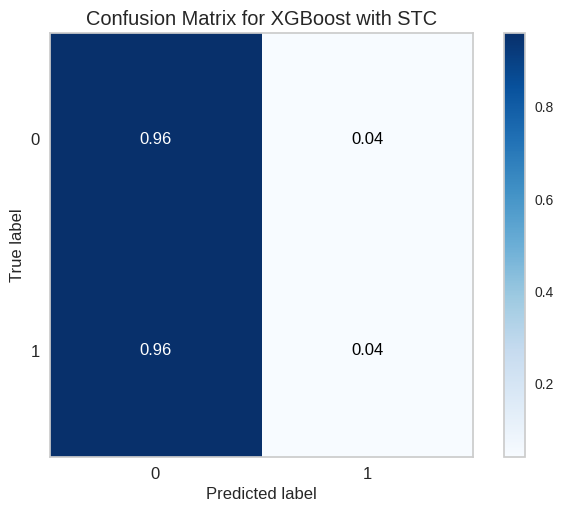

In [ ]:
skplt.metrics.plot_confusion_matrix(pred_reduced, df_results['xgboost'], normalize=True, title = 'Confusion Matrix for XGBoost with STC')


In [ ]:
print(accuracy_score(y_test, predictions))

0.4734970070269801


In [ ]:
print(accuracy_score(pred_reduced, predictions))

0.6194152858506116


Text(0.5, 1.0, 'Precision-Recall curve for XGBoost with KMeans')

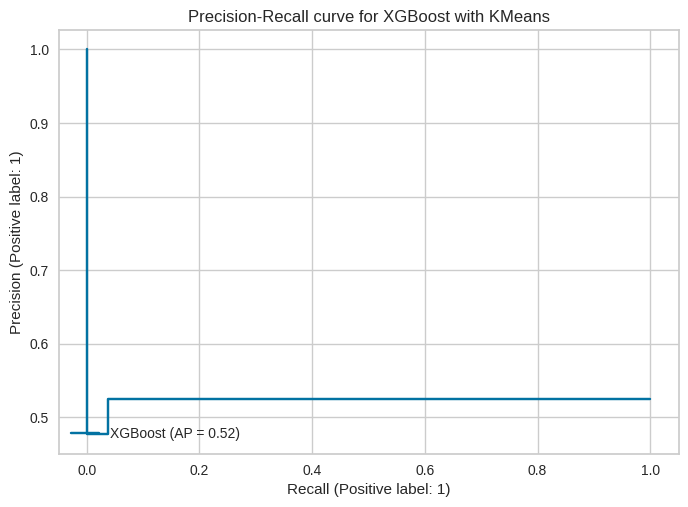

In [ ]:
display = PrecisionRecallDisplay.from_predictions(
    y_test, df_results['xgboost'], name="XGBoost"
)
display.ax_.set_title("Precision-Recall curve for XGBoost with KMeans")

Text(0.5, 1.0, 'Precision-Recall curve for XGBoost with STC')

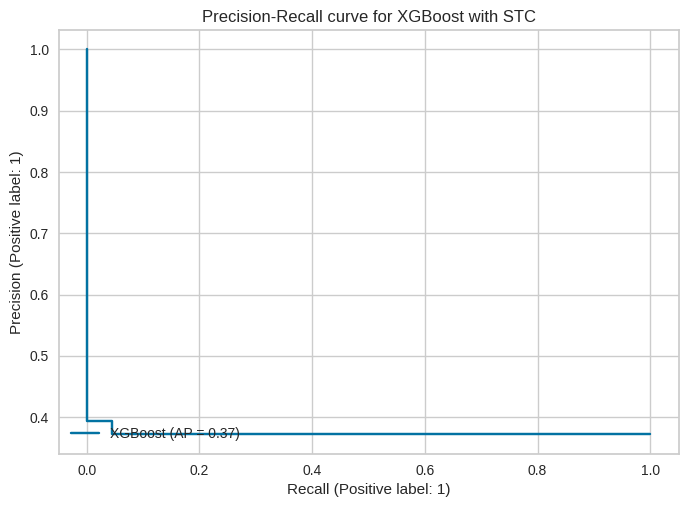

In [ ]:
display = PrecisionRecallDisplay.from_predictions(
    pred_reduced, df_results['xgboost'], name="XGBoost"
)
display.ax_.set_title("Precision-Recall curve for XGBoost with STC")

In [ ]:
from sklearn.metrics import roc_auc_score

auc = roc_auc_score(y_test, predictions)
print('AUC: %.2f' % auc)

AUC: 0.50


In [ ]:
# Hugging Face model
from transformers import pipeline

# Import flair pre-trained sentiment model
from flair.models import TextClassifier
classifier = TextClassifier.load('en-sentiment')

# Import flair Sentence to process input text
from flair.data import Sentence

# Import accuracy_score to check performance
from sklearn.metrics import accuracy_score

2024-03-29 03:24:54,703 https://nlp.informatik.hu-berlin.de/resources/models/sentiment-curated-distilbert/sentiment-en-mix-distillbert_4.pt not found in cache, downloading to /tmp/tmpudk9kleb


100%|██████████| 253M/253M [00:06<00:00, 38.5MB/s]

2024-03-29 03:25:01,754 copying /tmp/tmpudk9kleb to cache at /root/.flair/models/sentiment-en-mix-distillbert_4.pt


2024-03-29 03:25:02,013 removing temp file /tmp/tmpudk9kleb


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
df_test_copy_facezero = df_review.copy()
# Define pipeline
classifier = pipeline(task="zero-shot-classification",
                      model="facebook/bart-large-mnli",
                      device=0)
sequences = X_test.to_list()
candidate_labels = ["positive", "negative"]

# Set the hyppothesis template
hypothesis_template = "The sentiment of this review is {}."

# Prediction results
hf_prediction = classifier(sequences, candidate_labels, hypothesis_template=hypothesis_template)

# Save the output as a dataframe
df_test_copy_facezero = pd.DataFrame(hf_prediction)

config.json:   0%|          | 0.00/1.15k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [ ]:
# The column for the predicted topic
df_test_copy_facezero['hf_prediction'] = df_test_copy_facezero['labels'].apply(lambda x: x[0])

# Map sentiment values
df_test_copy_facezero['hf_prediction'] = df_test_copy_facezero['hf_prediction'].map({'positive': 1, 'negative': 0})

# The column for the score of predicted topic
df_test_copy_facezero['hf_predicted_score'] = df_test_copy_facezero['scores'].apply(lambda x: x[0])


# Drop the columns
df_test_copy_facezero = df_test_copy_facezero.drop(['labels', 'scores'], axis=1)

# Take a look at the data
df_test_copy_facezero.head()
df_review['hf_prediction'] = df_test_copy_facezero['hf_prediction']
df_review['hf_predicted_score'] = df_test_copy_facezero['hf_predicted_score']
df_results['hf_prediction'] = df_test_copy_facezero['hf_prediction']
df_results['hf_predicted_score'] = df_test_copy_facezero['hf_predicted_score']


In [ ]:
print(classification_report(y_test, df_test_copy_facezero['hf_prediction']))

              precision    recall  f1-score   support

           0       0.63      0.76      0.69     10961
           1       0.73      0.60      0.66     12093

    accuracy                           0.67     23054
   macro avg       0.68      0.68      0.67     23054
weighted avg       0.68      0.67      0.67     23054



In [ ]:
print(accuracy_score(y_test, df_test_copy_facezero['hf_prediction']))

0.6730285416847401


In [ ]:
print(classification_report(pred_reduced, df_test_copy_facezero['hf_prediction']))

              precision    recall  f1-score   support

           0       0.73      0.66      0.70     14487
           1       0.51      0.59      0.55      8567

    accuracy                           0.64     23054
   macro avg       0.62      0.63      0.62     23054
weighted avg       0.65      0.64      0.64     23054



In [ ]:
print(accuracy_score(pred_reduced, df_test_copy_facezero['hf_prediction']))

0.6367658540817211


<Axes: title={'center': 'Confusion Matrix for Flair with KMeans'}, xlabel='Predicted label', ylabel='True label'>

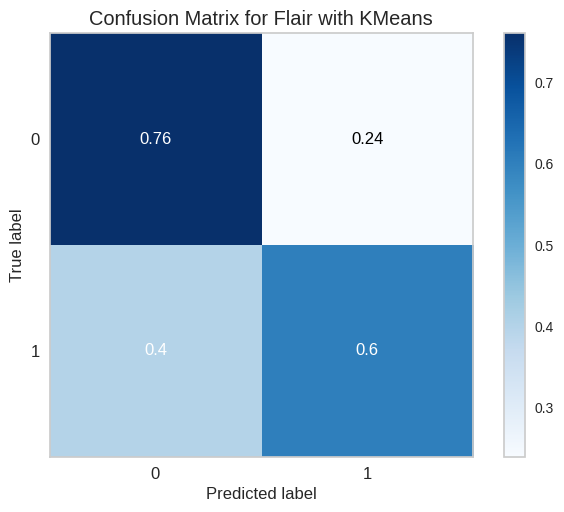

In [ ]:
skplt.metrics.plot_confusion_matrix(y_test, df_test_copy_facezero['hf_prediction'], normalize=True, title = 'Confusion Matrix for Flair with KMeans')
# skplt.metrics.plot_precision_recall(y_test, df_test_copy_facezero['hf_prediction'], title = 'PR Curve for Vader')
# skplt.metrics.plot_cumulative_gain(y_test, df_test_copy_facezero['hf_prediction'], title = 'Cumulative Gains Chart for Vader')

Text(0.5, 1.0, 'Precision-Recall curve for Flair with KMeans')

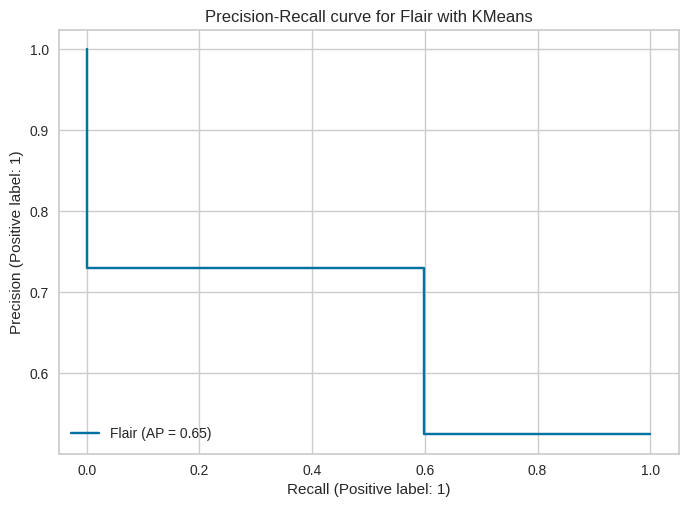

In [ ]:
display = PrecisionRecallDisplay.from_predictions(
    y_test, df_test_copy_facezero['hf_prediction'], name="Flair"
)
display.ax_.set_title("Precision-Recall curve for Flair with KMeans")

Text(0.5, 1.0, 'Precision-Recall curve for Flair with STC')

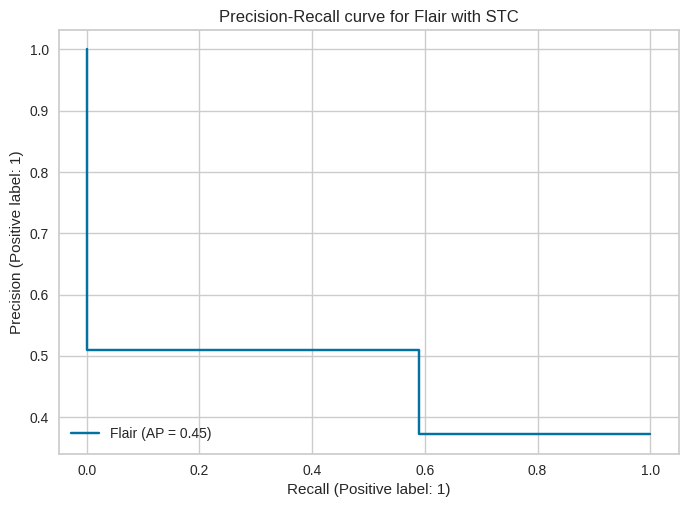

In [ ]:
display = PrecisionRecallDisplay.from_predictions(
    pred_reduced, df_test_copy_facezero['hf_prediction'], name="Flair"
)
display.ax_.set_title("Precision-Recall curve for Flair with STC")

<Axes: title={'center': 'Confusion Matrix for Flair with STC'}, xlabel='Predicted label', ylabel='True label'>

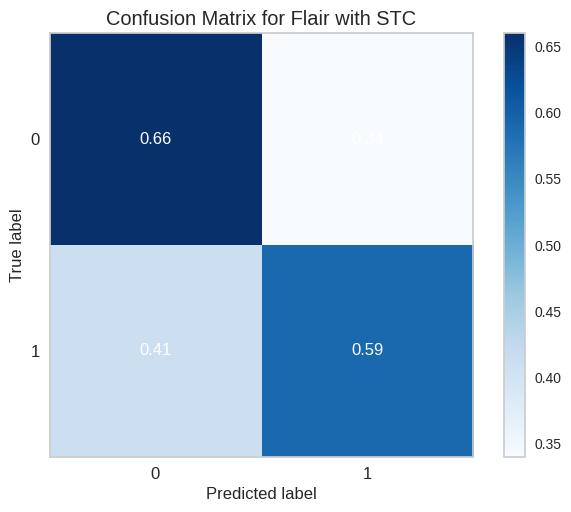

In [ ]:
skplt.metrics.plot_confusion_matrix(pred_reduced, df_test_copy_facezero['hf_prediction'], normalize=True, title = 'Confusion Matrix for Flair with STC')

In [ ]:
from sklearn.metrics import roc_curve

In [ ]:

from sklearn.metrics import roc_auc_score


In [ ]:
fpr1, tpr1, thresh1 = roc_curve(y_test, df_test_copy_facezero['hf_prediction'], pos_label=1)
fpr2, tpr2, thresh2 = roc_curve(y_test, df_results['xgboost'], pos_label=1)
fpr3, tpr3, thresh3 = roc_curve(y_test, vader_label, pos_label=1)
fpr4, tpr4, thresh4 = roc_curve(pred_reduced, df_test_copy_facezero['hf_prediction'], pos_label=1)
fpr5, tpr5, thresh5 = roc_curve(pred_reduced, df_results['xgboost'], pos_label=1)
fpr6, tpr6, thresh6 = roc_curve(pred_reduced, vader_label, pos_label=1)

<ipython-input-134-4dfa5905ffc5>:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


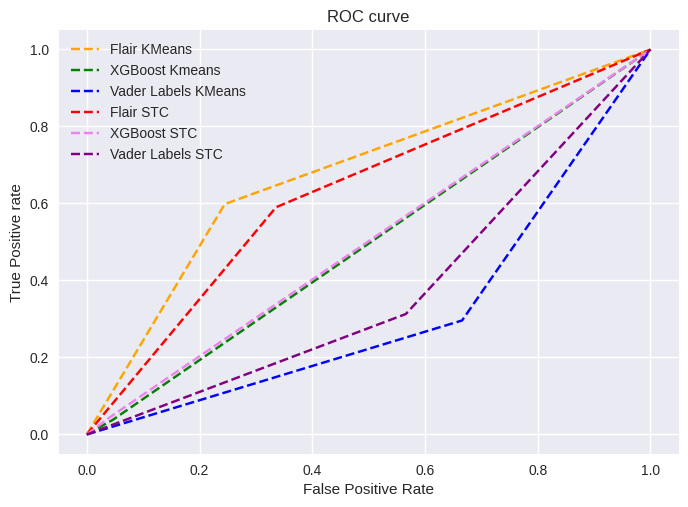

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('seaborn')

# plot roc curves
plt.plot(fpr1, tpr1, linestyle='--',color='orange', label='Flair KMeans')
plt.plot(fpr2, tpr2, linestyle='--',color='green', label='XGBoost Kmeans')
plt.plot(fpr3, tpr3, linestyle='--', color='blue', label = 'Vader Labels KMeans')
plt.plot(fpr4, tpr4, linestyle='--',color='red', label='Flair STC')
plt.plot(fpr5, tpr5, linestyle='--',color='violet', label='XGBoost STC')
plt.plot(fpr6, tpr6, linestyle='--', color='purple', label = 'Vader Labels STC')
# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
# plt.savefig('ROC',dpi=300)
plt.show();

In [ ]:

# # Visualization
# import plotly.express as px


# from sklearn.svm import SVC # for Support Vector Classification baseline model
# from sklearn.semi_supervised import SelfTrainingClassifier # for Semi-Supervised learning


In [ ]:
# df_reviews= = pd.read_csv('/gdrive/My Drive/review_agreement.csv')[df_reviews['majority']]